In [1]:
import torch
import albumentations
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

In [2]:
DATA_DIR = "../input/captcha-version-2-images/samples/"
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 8
EPOCHS = 200
DEVICE = "cuda"

In [3]:
class ClassificationDataset:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [
                albumentations.Normalize(
                    mean, std, max_pixel_value=255.0, always_apply=True)
            ])
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        targets = self.targets[item]
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        return{
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [4]:
import glob
import os
from torch import nn
from sklearn import preprocessing, model_selection, metrics
image_files = glob.glob(os.path.join(DATA_DIR, "*.png"))

In [5]:
targets_orig = [x.split("/")[-1][:-4] for x in image_files]
targets = [[c for c in x] for x in targets_orig]
targets_flat = [c for clist in targets for c in clist]

In [6]:
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc)
targets_enc = targets_enc+1

In [7]:
(
    train_imgs,
    test_imgs,
    train_targets,
    test_targets,
    _,
    test_targets_orig,
) = model_selection.train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=42
)

In [8]:
train_dataset = ClassificationDataset(
    image_paths = train_imgs,
    targets=train_targets,
    resize=(IMAGE_HEIGHT, IMAGE_WIDTH)
)

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle= True
)

In [10]:
test_dataset = ClassificationDataset(
    image_paths = test_imgs,
    targets=test_targets,
    resize=(IMAGE_HEIGHT, IMAGE_WIDTH)
)

In [11]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle= False
)

In [12]:
class CaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(CaptchaModel, self).__init__()
        self.conv1 = nn.Conv2d(3,128, kernel_size=(3,6), padding=(1,1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,6), padding=(1,1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        self.lstm = nn.GRU(64,32, bidirectional=True, num_layers=2, dropout=0.25, batch_first = True)
        self.output = nn.Linear(64, num_chars+1)
        
    def forward(self, images, targets=None):
        bs, _, _, _ = images.size()
        x = F.relu(self.conv1(images))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = F.relu(self.linear1(x))
        x = self.drop1(x)
        x, _ = self.lstm(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
            return x, loss

        return x, None


In [13]:
model = CaptchaModel(num_chars=len((lbl_enc.classes_)))
model.to(DEVICE)

CaptchaModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1152, out_features=64, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (lstm): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=20, bias=True)
)

In [14]:
tmp = iter(train_loader)
batch = next(tmp)
temp1 = batch["images"][0]
temp2 = batch["targets"][0]
temp1.shape, temp2.shape

(torch.Size([3, 75, 300]), torch.Size([5]))

In [15]:
temp1 = torch.unsqueeze(temp1,0)
temp1.shape

torch.Size([1, 3, 75, 300])

In [16]:
temp1 = temp1.cuda()
a = model(temp1)

In [17]:
a[0].shape

torch.Size([72, 1, 20])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [19]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [20]:
from tqdm import tqdm
def train_fn(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(DEVICE)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()
    return fin_loss/len(data_loader)

def eval_fn(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(DEVICE)
        batch_preds, loss = model(**data)
        fin_loss += loss.item()
        fin_preds.append(batch_preds)
    return fin_preds, fin_loss / len(data_loader)

In [21]:
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin


def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k = k - 1
            if k == -1:
                temp.append("§")
            else:
                p = encoder.inverse_transform([k])[0]
                temp.append(p)
        tp = "".join(temp).replace("§", "")
        cap_preds.append(remove_duplicates(tp))
    return cap_preds

In [22]:
for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, test_loss = eval_fn(model, test_loader)
    
    valid_captcha_preds = []
    
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_captcha_preds.extend(current_preds)
    combined = list(zip(test_targets_orig, valid_captcha_preds))
    print(combined[:10])
    test_dup_rem = [remove_duplicates(c) for c in test_targets_orig]
    accuracy = metrics.accuracy_score(test_dup_rem, valid_captcha_preds)
    print(
        f"Epoch={epoch}, Train Loss={train_loss}, Test Loss={test_loss} Accuracy={accuracy}"
    )
    scheduler.step(test_loss)

  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=0, Train Loss=7.727593827451396, Test Loss=3.323098604495709 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=1, Train Loss=3.3012658754984536, Test Loss=3.275886609004094 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=2, Train Loss=3.2700821986565223, Test Loss=3.2745504746070275 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=3, Train Loss=3.266515894832774, Test Loss=3.2741521321810207 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=4, Train Loss=3.266515921323727, Test Loss=3.2758710934565616 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=5, Train Loss=3.266215994826749, Test Loss=3.275085394199078 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=6, Train Loss=3.2664107298239684, Test Loss=3.276242677982037 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=7, Train Loss=3.2667232619391546, Test Loss=3.275590126331036 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=8, Train Loss=3.266157099324414, Test Loss=3.276467176584097 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=9, Train Loss=3.266575868313129, Test Loss=3.278356515444242 Accuracy=0.0
Epoch    10: reducing learning rate of group 0 to 2.4000e-04.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=10, Train Loss=3.265065252271473, Test Loss=3.2739277619581957 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=11, Train Loss=3.264965595343174, Test Loss=3.274628969339224 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=12, Train Loss=3.265447109173506, Test Loss=3.274950394263634 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=13, Train Loss=3.264871562648023, Test Loss=3.274160091693585 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=14, Train Loss=3.264893743726942, Test Loss=3.2713040755345273 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=15, Train Loss=3.2643734756697955, Test Loss=3.2713676415956936 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=16, Train Loss=3.2609420882331, Test Loss=3.273721511547382 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=17, Train Loss=3.2550213092412705, Test Loss=3.2659550446730394 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=18, Train Loss=3.2397711664183526, Test Loss=3.2496528992286096 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=19, Train Loss=3.205314729967688, Test Loss=3.1856363186469445 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=20, Train Loss=3.12999154563643, Test Loss=3.098878952173086 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=21, Train Loss=3.012611042739999, Test Loss=2.923830949343168 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', ''), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', ''), ('pe4xn', '')]
Epoch=22, Train Loss=2.8551330383007345, Test Loss=2.7753201998197117 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', 'f'), ('8n5pn', ''), ('c2fb7', ''), ('n7enn', ''), ('fxpw3', 'f'), ('pe4xn', '')]
Epoch=23, Train Loss=2.6425430591289816, Test Loss=2.467276591521043 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', ''), ('wd2gb', ''), ('wnpec', ''), ('nfbg8', 'f'), ('8n5pn', ''), ('c2fb7', 'f'), ('n7enn', ''), ('fxpw3', 'f'), ('pe4xn', '')]
Epoch=24, Train Loss=2.350161147932721, Test Loss=2.074838482416593 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', ''), ('pbpgc', 'b'), ('wd2gb', 'b'), ('wnpec', ''), ('nfbg8', 'fb'), ('8n5pn', '5'), ('c2fb7', 'fb'), ('n7enn', '7'), ('fxpw3', 'f'), ('pe4xn', '')]
Epoch=25, Train Loss=1.9895245142472096, Test Loss=1.6351397312604463 Accuracy=0.0


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '42'), ('pbpgc', 'b'), ('wd2gb', '2gb'), ('wnpec', 'pc'), ('nfbg8', 'fbg8'), ('8n5pn', '85p'), ('c2fb7', '2fb7'), ('n7enn', '7'), ('fxpw3', 'fx3'), ('pe4xn', 'p4x')]
Epoch=26, Train Loss=1.617078473425319, Test Loss=1.2557270526885986 Accuracy=0.038461538461538464


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpg'), ('wd2gb', 'd2gb'), ('wnpec', 'pc'), ('nfbg8', 'fbg8'), ('8n5pn', '85p'), ('c2fb7', '2fb7'), ('n7enn', '7'), ('fxpw3', 'fxp3'), ('pe4xn', 'p4x')]
Epoch=27, Train Loss=1.2910792970249796, Test Loss=0.9368771268771245 Accuracy=0.08653846153846154


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'd2gb'), ('wnpec', 'pec'), ('nfbg8', 'fbg8'), ('8n5pn', '85p'), ('c2fb7', '2fb7'), ('n7enn', '7e'), ('fxpw3', 'fxp3'), ('pe4xn', 'pe4x')]
Epoch=28, Train Loss=1.0358863539165921, Test Loss=0.7162209519973168 Accuracy=0.17307692307692307


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'd2gb'), ('wnpec', 'pec'), ('nfbg8', 'fbg8'), ('8n5pn', '85p'), ('c2fb7', '2fb7'), ('n7enn', '7e'), ('fxpw3', 'fxp3'), ('pe4xn', 'pe4x')]
Epoch=29, Train Loss=0.819451407999055, Test Loss=0.5649583889887884 Accuracy=0.20192307692307693


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'd2gb'), ('wnpec', 'pec'), ('nfbg8', 'fbg8'), ('8n5pn', '85p'), ('c2fb7', 'c2fb7'), ('n7enn', '7e'), ('fxpw3', 'fxp3'), ('pe4xn', 'pe4x')]
Epoch=30, Train Loss=0.6774785887991261, Test Loss=0.47980576753616333 Accuracy=0.27884615384615385


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'npec'), ('nfbg8', 'fbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'e2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxp3'), ('pe4xn', 'pe4xn')]
Epoch=31, Train Loss=0.5697317166715605, Test Loss=0.41304123401641846 Accuracy=0.5


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'fbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxp3'), ('pe4xn', 'pe4xn')]
Epoch=32, Train Loss=0.4993039491849068, Test Loss=0.36252356377931744 Accuracy=0.5961538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=33, Train Loss=0.44367173543343175, Test Loss=0.3269139677286148 Accuracy=0.6923076923076923


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'e2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=34, Train Loss=0.3992523419806081, Test Loss=0.2943506962977923 Accuracy=0.7307692307692307


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', '2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=35, Train Loss=0.3613382924316276, Test Loss=0.26370810660032123 Accuracy=0.6923076923076923


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'e2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=36, Train Loss=0.32670378302916503, Test Loss=0.25250363177978075 Accuracy=0.7307692307692307


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'e2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=37, Train Loss=0.3018342544380416, Test Loss=0.23948526267821973 Accuracy=0.7403846153846154


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'npec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=38, Train Loss=0.27177752872817534, Test Loss=0.2045104870429406 Accuracy=0.7019230769230769


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'npec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=39, Train Loss=0.25299608471811325, Test Loss=0.19640483821813876 Accuracy=0.7115384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=40, Train Loss=0.2314053531895336, Test Loss=0.19324462173076776 Accuracy=0.7788461538461539


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=41, Train Loss=0.22302930483705977, Test Loss=0.1795110905972811 Accuracy=0.7884615384615384


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=42, Train Loss=0.20260223829083973, Test Loss=0.17914277487076247 Accuracy=0.7692307692307693


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=43, Train Loss=0.19728107502063116, Test Loss=0.1632210655281177 Accuracy=0.7980769230769231


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=44, Train Loss=0.18292042683077675, Test Loss=0.15904401156764764 Accuracy=0.8076923076923077


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=45, Train Loss=0.17228055458802444, Test Loss=0.1527846111701085 Accuracy=0.7884615384615384


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=46, Train Loss=0.1619755762000369, Test Loss=0.14315659352220023 Accuracy=0.8076923076923077


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=47, Train Loss=0.15962354727407807, Test Loss=0.14574974918594727 Accuracy=0.8076923076923077


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=48, Train Loss=0.14920986144461185, Test Loss=0.13172097647419342 Accuracy=0.7884615384615384


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=49, Train Loss=0.138514732894225, Test Loss=0.13330907517900834 Accuracy=0.7980769230769231


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wmpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=50, Train Loss=0.12519772914357674, Test Loss=0.10875292566533272 Accuracy=0.8076923076923077


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wmnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7enmn'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=51, Train Loss=0.12264522741365637, Test Loss=0.09889364185241553 Accuracy=0.8557692307692307


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=52, Train Loss=0.11217955296110903, Test Loss=0.10917042811902669 Accuracy=0.8269230769230769


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'ce2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=53, Train Loss=0.08998477866506985, Test Loss=0.0726241311774804 Accuracy=0.9326923076923077


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=54, Train Loss=0.08590268174934591, Test Loss=0.07767789194790217 Accuracy=0.9134615384615384


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=55, Train Loss=0.0716168614757112, Test Loss=0.068069806179175 Accuracy=0.9519230769230769


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=56, Train Loss=0.05997319099230644, Test Loss=0.05845513595984532 Accuracy=0.9423076923076923


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=57, Train Loss=0.05682071806210229, Test Loss=0.07226453320338176 Accuracy=0.9134615384615384


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=58, Train Loss=0.05010604391941148, Test Loss=0.05485902053232376 Accuracy=0.9519230769230769


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=59, Train Loss=0.043303124972770356, Test Loss=0.055394006749758355 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=60, Train Loss=0.042520626328694515, Test Loss=0.06039092166779133 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=61, Train Loss=0.03673223483288645, Test Loss=0.05172921298071742 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=62, Train Loss=0.03871389942514336, Test Loss=0.05283606145530939 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'npec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=63, Train Loss=0.0314727643202258, Test Loss=0.059394250194040626 Accuracy=0.9519230769230769


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=64, Train Loss=0.035542703345099576, Test Loss=0.06121327910715571 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=65, Train Loss=0.02522759896535904, Test Loss=0.05722836111314022 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=66, Train Loss=0.030813339588224378, Test Loss=0.061891544538621716 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=67, Train Loss=0.02697359887548746, Test Loss=0.06017325406607527 Accuracy=0.9711538461538461
Epoch    68: reducing learning rate of group 0 to 1.9200e-04.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=68, Train Loss=0.0234503243994127, Test Loss=0.06188881264712948 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=69, Train Loss=0.01875706376014357, Test Loss=0.06434544856445147 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=70, Train Loss=0.024392045807475463, Test Loss=0.05499354961256568 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=71, Train Loss=0.021033329260336537, Test Loss=0.0600163596861351 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=72, Train Loss=0.018850821488274213, Test Loss=0.05747223740371947 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=73, Train Loss=0.019272425052765597, Test Loss=0.06092731629569943 Accuracy=0.9615384615384616
Epoch    74: reducing learning rate of group 0 to 1.5360e-04.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=74, Train Loss=0.017105594229621764, Test Loss=0.06001316107666263 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=75, Train Loss=0.02194933054777674, Test Loss=0.06528926128521562 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=76, Train Loss=0.014407943572021194, Test Loss=0.0606919582395886 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=77, Train Loss=0.015469123649164142, Test Loss=0.06725707275864597 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=78, Train Loss=0.01821162682185825, Test Loss=0.06077113425215849 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=79, Train Loss=0.013009802422398685, Test Loss=0.06705805489148658 Accuracy=0.9615384615384616
Epoch    80: reducing learning rate of group 0 to 1.2288e-04.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=80, Train Loss=0.011765365365446888, Test Loss=0.06602690145015143 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=81, Train Loss=0.014711946286818283, Test Loss=0.06053726964343626 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=82, Train Loss=0.012561910401663592, Test Loss=0.06795187407316497 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=83, Train Loss=0.010266332023450706, Test Loss=0.06678081089809823 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=84, Train Loss=0.01044982767655936, Test Loss=0.06123597429205592 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=85, Train Loss=0.010713302138317218, Test Loss=0.06581053752093934 Accuracy=0.9615384615384616
Epoch    86: reducing learning rate of group 0 to 9.8304e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=86, Train Loss=0.008125597692659905, Test Loss=0.06451627736588797 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=87, Train Loss=0.00985668245384581, Test Loss=0.06237437006515952 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=88, Train Loss=0.009307774589755215, Test Loss=0.05934027151670307 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=89, Train Loss=0.0073876769727685004, Test Loss=0.06646116414608863 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=90, Train Loss=0.009038704580778623, Test Loss=0.06387543467840609 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=91, Train Loss=0.009865280117393814, Test Loss=0.06178274616384162 Accuracy=0.9711538461538461
Epoch    92: reducing learning rate of group 0 to 7.8643e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=92, Train Loss=0.009587146319910629, Test Loss=0.0681715454064453 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=93, Train Loss=0.0066374928121351534, Test Loss=0.06594965310516553 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=94, Train Loss=0.008328327019579517, Test Loss=0.06868679616421175 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=95, Train Loss=0.006599191108591154, Test Loss=0.06599064719361755 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=96, Train Loss=0.007064244624338726, Test Loss=0.06597986378563711 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=97, Train Loss=0.006657115275310909, Test Loss=0.06415665141629198 Accuracy=0.9711538461538461
Epoch    98: reducing learning rate of group 0 to 6.2915e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=98, Train Loss=0.005822704802466254, Test Loss=0.06592010686066575 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=99, Train Loss=0.0070083875061832685, Test Loss=0.06894786813511299 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=100, Train Loss=0.006364354055820622, Test Loss=0.06405283998733816 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=101, Train Loss=0.005762480175456939, Test Loss=0.06361995755623166 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=102, Train Loss=0.00533850687261448, Test Loss=0.06754858808842702 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=103, Train Loss=0.004761627029516121, Test Loss=0.0671934701788884 Accuracy=0.9711538461538461
Epoch   104: reducing learning rate of group 0 to 5.0332e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=104, Train Loss=0.005358299312110131, Test Loss=0.06629301587012239 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=105, Train Loss=0.006080830288637016, Test Loss=0.0699096774109281 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=106, Train Loss=0.005054442034875099, Test Loss=0.06998878455935763 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=107, Train Loss=0.005651889896243174, Test Loss=0.0648953705542506 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=108, Train Loss=0.004192313094798507, Test Loss=0.06796152852117442 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=109, Train Loss=0.006599072881369318, Test Loss=0.0631778823131194 Accuracy=0.9711538461538461
Epoch   110: reducing learning rate of group 0 to 4.0265e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=110, Train Loss=0.005693680807772992, Test Loss=0.06375972796321058 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=111, Train Loss=0.006214699073113564, Test Loss=0.0645123359729321 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=112, Train Loss=0.004975752130899037, Test Loss=0.06432734989525321 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=113, Train Loss=0.0050276870646267235, Test Loss=0.06282614323740396 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=114, Train Loss=0.004951470315607631, Test Loss=0.06528825740903042 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=115, Train Loss=0.005410902602120469, Test Loss=0.06300037700342588 Accuracy=0.9711538461538461
Epoch   116: reducing learning rate of group 0 to 3.2212e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=116, Train Loss=0.004333323639873256, Test Loss=0.06701143472813643 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=117, Train Loss=0.005413767231954659, Test Loss=0.06601909889230648 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=118, Train Loss=0.004865570604785258, Test Loss=0.06684215942648454 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=119, Train Loss=0.004069219765245405, Test Loss=0.0678336566242461 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=120, Train Loss=0.0037767102953810724, Test Loss=0.06689652818470047 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=121, Train Loss=0.004718899164691121, Test Loss=0.06833389532179214 Accuracy=0.9711538461538461
Epoch   122: reducing learning rate of group 0 to 2.5770e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=122, Train Loss=0.005056195571007701, Test Loss=0.06566589648047319 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=123, Train Loss=0.003780634647919836, Test Loss=0.06687133294494393 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=124, Train Loss=0.004367697164097913, Test Loss=0.06898478922756532 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=125, Train Loss=0.003368786405811771, Test Loss=0.06961741140380931 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=126, Train Loss=0.004217550065965416, Test Loss=0.06843566658566348 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=127, Train Loss=0.0033612181820596256, Test Loss=0.06850591177890937 Accuracy=0.9711538461538461
Epoch   128: reducing learning rate of group 0 to 2.0616e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=128, Train Loss=0.0035507790724404603, Test Loss=0.06807068256715026 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=129, Train Loss=0.007655017445078836, Test Loss=0.06688959897012235 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=130, Train Loss=0.004795486711435275, Test Loss=0.06762703740521549 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=131, Train Loss=0.0052290594724651715, Test Loss=0.06825178631473906 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=132, Train Loss=0.003948124009184539, Test Loss=0.06859134333297753 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=133, Train Loss=0.00379840075237374, Test Loss=0.07056381260134423 Accuracy=0.9615384615384616
Epoch   134: reducing learning rate of group 0 to 1.6493e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=134, Train Loss=0.004411475421486693, Test Loss=0.07101475424580993 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=135, Train Loss=0.0048680907855622275, Test Loss=0.07085075178810467 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=136, Train Loss=0.0032537455559095256, Test Loss=0.07128766633104533 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=137, Train Loss=0.004040638511228319, Test Loss=0.07013027045356396 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=138, Train Loss=0.004825398638350968, Test Loss=0.07110193683855379 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=139, Train Loss=0.0029885936508544236, Test Loss=0.07067872675207372 Accuracy=0.9711538461538461
Epoch   140: reducing learning rate of group 0 to 1.3194e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=140, Train Loss=0.004251159616133086, Test Loss=0.07066781709167677 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=141, Train Loss=0.004174562468607392, Test Loss=0.0699750789342663 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=142, Train Loss=0.003760858758304937, Test Loss=0.07050599940479375 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=143, Train Loss=0.003977434447982436, Test Loss=0.07045147990216859 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=144, Train Loss=0.0029666784366704207, Test Loss=0.07028480443673638 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=145, Train Loss=0.004897733585128927, Test Loss=0.07110967238147098 Accuracy=0.9711538461538461
Epoch   146: reducing learning rate of group 0 to 1.0555e-05.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=146, Train Loss=0.0042217027388003646, Test Loss=0.07125656814941277 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=147, Train Loss=0.0026892844545774353, Test Loss=0.07104322509481929 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=148, Train Loss=0.0028901338282749695, Test Loss=0.07146488294865076 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=149, Train Loss=0.0028789519923380935, Test Loss=0.07106395320107158 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=150, Train Loss=0.004516857471237453, Test Loss=0.07085389024219833 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=151, Train Loss=0.002852805319011339, Test Loss=0.07089084464286526 Accuracy=0.9711538461538461
Epoch   152: reducing learning rate of group 0 to 8.4442e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=152, Train Loss=0.0044292668915457195, Test Loss=0.0701503947045869 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=153, Train Loss=0.003416919379304044, Test Loss=0.06982639761946093 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=154, Train Loss=0.0027579116370353815, Test Loss=0.06996722498801179 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=155, Train Loss=0.002372156910232117, Test Loss=0.07033327453805563 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=156, Train Loss=0.00300035908475964, Test Loss=0.07095608609513594 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=157, Train Loss=0.002807818041740256, Test Loss=0.07033230860431033 Accuracy=0.9711538461538461
Epoch   158: reducing learning rate of group 0 to 6.7554e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=158, Train Loss=0.0037202822028571726, Test Loss=0.0698740275693126 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=159, Train Loss=0.0025877115838070456, Test Loss=0.06994112089831525 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=160, Train Loss=0.0031154988508703364, Test Loss=0.06946394114325252 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=161, Train Loss=0.0044061331691331845, Test Loss=0.07002130850630167 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=162, Train Loss=0.0032254434956842637, Test Loss=0.07037232826517609 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=163, Train Loss=0.0032982128019579966, Test Loss=0.07026108941331935 Accuracy=0.9711538461538461
Epoch   164: reducing learning rate of group 0 to 5.4043e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=164, Train Loss=0.002555524255746068, Test Loss=0.07028472705188996 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=165, Train Loss=0.004583574934966034, Test Loss=0.07063536841171579 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=166, Train Loss=0.0024434821491137655, Test Loss=0.07073362984766181 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=167, Train Loss=0.0025714409754523993, Test Loss=0.07058459326015928 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=168, Train Loss=0.004488999650885279, Test Loss=0.07034014031523839 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=169, Train Loss=0.0034876758795884303, Test Loss=0.07035217900724652 Accuracy=0.9711538461538461
Epoch   170: reducing learning rate of group 0 to 4.3235e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=170, Train Loss=0.00281168159065593, Test Loss=0.07020014134468511 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=171, Train Loss=0.0036645515435813074, Test Loss=0.07014242406092727 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=172, Train Loss=0.003194977807947713, Test Loss=0.069879284952409 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=173, Train Loss=0.003450768630609362, Test Loss=0.07006674276020092 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=174, Train Loss=0.004147666833825154, Test Loss=0.0698542030250582 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=175, Train Loss=0.0024599393523242483, Test Loss=0.06981301885277319 Accuracy=0.9615384615384616
Epoch   176: reducing learning rate of group 0 to 3.4588e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=176, Train Loss=0.004051808500662446, Test Loss=0.06942112889373675 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=177, Train Loss=0.002977207492097703, Test Loss=0.06940685136494441 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=178, Train Loss=0.003563242649030673, Test Loss=0.06952614415114602 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=179, Train Loss=0.002479404436909936, Test Loss=0.06961589663002926 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=180, Train Loss=0.002951566310018365, Test Loss=0.07008275302359834 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=181, Train Loss=0.003433453924078335, Test Loss=0.07049702236410947 Accuracy=0.9711538461538461
Epoch   182: reducing learning rate of group 0 to 2.7670e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=182, Train Loss=0.002635557731836397, Test Loss=0.07041241525887297 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=183, Train Loss=0.0027238972267159857, Test Loss=0.07049035475714706 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=184, Train Loss=0.0028826022047040043, Test Loss=0.07046425230622005 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=185, Train Loss=0.0029859228833761606, Test Loss=0.07076864664066726 Accuracy=0.9711538461538461


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=186, Train Loss=0.002883907462247353, Test Loss=0.07064762519887434 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=187, Train Loss=0.00259491339381625, Test Loss=0.07068916929151434 Accuracy=0.9615384615384616
Epoch   188: reducing learning rate of group 0 to 2.2136e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=188, Train Loss=0.0021712764287685864, Test Loss=0.07058666392605609 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=189, Train Loss=0.003282140111590489, Test Loss=0.07042003807593854 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=190, Train Loss=0.002855582434373597, Test Loss=0.07025691397183646 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=191, Train Loss=0.0034506542714607194, Test Loss=0.07028173954369357 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=192, Train Loss=0.002877461437422496, Test Loss=0.07022614870668174 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=193, Train Loss=0.003479245614308195, Test Loss=0.07012733785310186 Accuracy=0.9615384615384616
Epoch   194: reducing learning rate of group 0 to 1.7709e-06.


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=194, Train Loss=0.003442990552817081, Test Loss=0.06998950695224966 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=195, Train Loss=0.002374319087029395, Test Loss=0.07015459394852559 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=196, Train Loss=0.004086756017098888, Test Loss=0.07017856642890435 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=197, Train Loss=0.002314455211202367, Test Loss=0.07026435983313534 Accuracy=0.9615384615384616


  0%|          | 0/117 [00:00<?, ?it/s]

[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=198, Train Loss=0.002634983843104898, Test Loss=0.07032449519297537 Accuracy=0.9615384615384616


100%|██████████| 13/13 [00:00<00:00, 19.39it/s]


[('44c22', '4c2'), ('pbpgc', 'pbpgc'), ('wd2gb', 'wd2gb'), ('wnpec', 'wnpec'), ('nfbg8', 'nfbg8'), ('8n5pn', '8n5pn'), ('c2fb7', 'c2fb7'), ('n7enn', 'n7en'), ('fxpw3', 'fxpw3'), ('pe4xn', 'pe4xn')]
Epoch=199, Train Loss=0.0027286404292059378, Test Loss=0.07024969915913132 Accuracy=0.9615384615384616
Epoch   200: reducing learning rate of group 0 to 1.4167e-06.


In [23]:
tmp = iter(test_loader)
batch = next(tmp)
temp1 = batch["images"][0]
temp2 = batch['targets'][0]
temp1.shape, temp2.shape

(torch.Size([3, 75, 300]), torch.Size([5]))

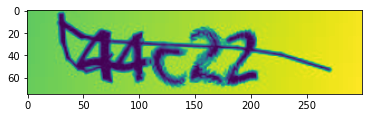

In [24]:
plt.imshow(temp1[0])

In [25]:
model.eval()
# model = CaptchaModel(num_chars=len((lbl_enc.classes_)))
lbl_enc.classes_

array(['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g',
       'm', 'n', 'p', 'w', 'x', 'y'], dtype='<U1')

In [26]:
temp1 = temp1.cuda()
temp1 = torch.unsqueeze(temp1, 0)
temp1.shape

torch.Size([1, 3, 75, 300])

In [27]:
x, y = model(temp1)

In [28]:
preds = decode_predictions(x, lbl_enc)

In [29]:
preds

['4c2']

In [30]:
temp2

tensor([3, 3, 9, 1, 1])

In [31]:
for t in temp2:
    print(lbl_enc.classes_[t-1],end='')

44c22

In [32]:
model.eval()
torch.save({
    'epoch':EPOCHS,
    'model': model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    'loss': 0.036
}, 'crnn1.pt')